In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, RepeatedStratifiedKFold,KFold,train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, roc_curve, auc, roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.ensemble import IsolationForest, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import LocalOutlierFactor 
from sklearn.feature_selection import SelectKBest, chi2, RFE, f_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

import statsmodels.api as sm

from functools import reduce

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#locate the data
!ls "../content/drive/My Drive/Colab Notebooks/Udacity"

AB-test-new-menu-launch.ipynb  round-roaster-store.csv
credit-data-training.csv       RoundRoastersTransactions.csv
customers-to-score.csv	       treatment-stores.csv
Predicting-Default-Risk.ipynb


In [4]:
df = pd.read_csv("../content/drive/My Drive/Colab Notebooks/Udacity/credit-data-training.csv")
df

,Credit-Application-Result,Account-Balance,Duration-of-Credit-Month,Payment-Status-of-Previous-Credit,Purpose,Credit-Amount,Value-Savings-Stocks,Length-of-current-employment,Instalment-per-cent,Guarantors,Duration-in-Current-address,Most-valuable-available-asset,Age-years,Concurrent-Credits,Type-of-apartment,No-of-Credits-at-this-Bank,Occupation,No-of-dependents,Telephone,Foreign-Worker
0,Creditworthy,Some Balance,4,Paid Up,Other,1494,£100-£1000,< 1yr,1,None,2.0,1,NaN,Other Banks/Depts,2,1,1,2,1,2
1,Creditworthy,Some Balance,4,Paid Up,Home Related,1494,£100-£1000,< 1yr,1,None,2.0,1,29.0,Other Banks/Depts,2,1,1,2,1,2
2,Creditworthy,Some Balance,4,No Problems (in this bank),Home Related,1544,None,1-4 yrs,2,None,1.0,1,42.0,Other Banks/Depts,2,More than 1,1,2,1,1
3,Creditworthy,Some Balance,4,No Problems (in this bank),Home Related,3380,None,1-4 yrs,1,None,1.0,1,37.0,Other Banks/Depts,2,1,1,2,1,1
4,Creditworthy,No Account,6,Paid Up,Home Related,343,None,< 1yr,4,None,1.0,1,27.0,Other Banks/Depts,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,Creditworthy,No Account,60,No Problems (in this bank),Other,7418,£100-£1000,< 1yr,1,None,1.0,1,NaN,Other Banks/Depts,2,1,1,1,1,1
496,Creditworthy,No Account,60,No Problems (in this bank),Home Related,7418,£100-£1000,< 1yr,1,None,1.0,1,27.0,Other Banks/Depts,2,1,1,1,1,1
497,Creditworthy,No Account,60,No Problems (in this bank),Home Related,9157,£100-£1000,< 1yr,2,None,NaN,4,27.0,Other Banks/Depts,3,1,1,1,1,1
498,Creditworthy,Some Balance,60,No Problems (in this bank),Home Related,13756,£100-£1000,4-7 yrs,2,None,NaN,4,63.0,Other Banks/Depts,3,1,1,1,2,1


In [5]:
df['Credit-Application-Result'].unique()

array(['Creditworthy', 'Non-Creditworthy'], dtype=object)

In [6]:
df['Credit-Application-Result'].replace({"Creditworthy": 1, "Non-Creditworthy": 0}, inplace=True)

In [7]:
df['Account-Balance'].unique()

array(['Some Balance', 'No Account'], dtype=object)

In [8]:
df['Account-Balance'].replace({'Some Balance': 1, 'No Account': 0}, inplace=True)

In [9]:
df['Payment-Status-of-Previous-Credit'].unique()

array(['Paid Up', 'No Problems (in this bank)', 'Some Problems'],
      dtype=object)

In [10]:
df['Payment-Status-of-Previous-Credit'].replace({'Paid Up': 2, 'No Problems (in this bank)': 1, 'Some Problems': 0}, inplace=True)

In [11]:
df['Purpose'].unique()

array(['Other', 'Home Related', 'Used car', 'New car'], dtype=object)

In [12]:
df['Purpose'].replace({
                    'New car': 3, 
                    'Used car': 2,
                    'Home Related': 1,
                    'Other': 0}, inplace=True)

In [13]:
df['Value-Savings-Stocks'].unique()

array(['£100-£1000', 'None', '< £100'], dtype=object)

In [14]:
df['Value-Savings-Stocks'].replace({
                    '< £100': 2, 
                    '£100-£1000': 1,
                    'None': 0}, inplace=True)

In [15]:
df['Length-of-current-employment'].unique()

array(['< 1yr', '1-4 yrs', '4-7 yrs'], dtype=object)

In [16]:
df['Length-of-current-employment'].replace({
                    '4-7 yrs': 2, 
                    '1-4 yrs': 1,
                    '< 1yr': 0}, inplace=True)

In [17]:
df['Concurrent-Credits'].unique()

array(['Other Banks/Depts'], dtype=object)

In [18]:
df['Concurrent-Credits'].replace({'Other Banks/Depts': 1}, inplace=True)

In [19]:
df['No-of-Credits-at-this-Bank'].unique()

array(['1', 'More than 1'], dtype=object)

In [20]:
df['No-of-Credits-at-this-Bank'].replace({'More than 1': 1, '1': 0}, inplace=True)

In [21]:
df["Guarantors"].unique()

array(['None', 'Yes'], dtype=object)

In [22]:
df['Guarantors'].replace({'Yes': 1, 'None': 0}, inplace=True)

In [23]:
df.describe()

,Credit-Application-Result,Account-Balance,Duration-of-Credit-Month,Payment-Status-of-Previous-Credit,Purpose,Credit-Amount,Value-Savings-Stocks,Length-of-current-employment,Instalment-per-cent,Guarantors,Duration-in-Current-address,Most-valuable-available-asset,Age-years,Concurrent-Credits,Type-of-apartment,No-of-Credits-at-this-Bank,Occupation,No-of-dependents,Telephone,Foreign-Worker
count,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,156.000000,500.000000,488.000000,500.0,500.000000,500.000000,500.0,500.00000,500.000000,500.000000
mean,0.716000,0.476000,21.43400,1.448000,1.324000,3199.980000,0.500000,0.690000,3.010000,0.086000,2.660256,2.360000,35.637295,1.0,1.928000,0.360000,1.0,1.14600,1.400000,1.038000
std,0.451388,0.499924,12.30742,0.626163,0.684076,2831.386861,0.665497,0.843399,1.113724,0.280645,1.150017,1.064268,11.501522,0.0,0.539814,0.480481,0.0,0.35346,0.490389,0.191388
min,0.000000,0.000000,4.00000,0.000000,0.000000,276.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,19.000000,1.0,1.000000,0.000000,1.0,1.00000,1.000000,1.000000
25%,0.000000,0.000000,12.00000,1.000000,1.000000,1357.250000,0.000000,0.000000,2.000000,0.000000,2.000000,1.000000,27.000000,1.0,2.000000,0.000000,1.0,1.00000,1.000000,1.000000
50%,1.000000,0.000000,18.00000,2.000000,1.000000,2236.500000,0.000000,0.000000,3.000000,0.000000,2.000000,3.000000,33.000000,1.0,2.000000,0.000000,1.0,1.00000,1.000000,1.000000
75%,1.000000,1.000000,24.00000,2.000000,2.000000,3941.500000,1.000000,1.000000,4.000000,0.000000,4.000000,3.000000,42.000000,1.0,2.000000,1.000000,1.0,1.00000,2.000000,1.000000
max,1.000000,1.000000,60.00000,2.000000,3.000000,18424.000000,2.000000,2.000000,4.000000,1.000000,4.000000,4.000000,75.000000,1.0,3.000000,1.000000,1.0,2.00000,2.000000,2.000000


## Data cleanup

**Checking null values**

In [24]:
df.isnull().sum()

Credit-Application-Result              0
Account-Balance                        0
Duration-of-Credit-Month               0
Payment-Status-of-Previous-Credit      0
Purpose                                0
Credit-Amount                          0
Value-Savings-Stocks                   0
Length-of-current-employment           0
Instalment-per-cent                    0
Guarantors                             0
Duration-in-Current-address          344
Most-valuable-available-asset          0
Age-years                             12
Concurrent-Credits                     0
Type-of-apartment                      0
No-of-Credits-at-this-Bank             0
Occupation                             0
No-of-dependents                       0
Telephone                              0
Foreign-Worker                         0
dtype: int64

In [25]:
df = df.fillna(round(df.median()))

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Credit-Application-Result          500 non-null    int64  
 1   Account-Balance                    500 non-null    int64  
 2   Duration-of-Credit-Month           500 non-null    int64  
 3   Payment-Status-of-Previous-Credit  500 non-null    int64  
 4   Purpose                            500 non-null    int64  
 5   Credit-Amount                      500 non-null    int64  
 6   Value-Savings-Stocks               500 non-null    int64  
 7   Length-of-current-employment       500 non-null    int64  
 8   Instalment-per-cent                500 non-null    int64  
 9   Guarantors                         500 non-null    int64  
 10  Duration-in-Current-address        500 non-null    float64
 11  Most-valuable-available-asset      500 non-null    int64  

In [27]:
df.describe()

,Credit-Application-Result,Account-Balance,Duration-of-Credit-Month,Payment-Status-of-Previous-Credit,Purpose,Credit-Amount,Value-Savings-Stocks,Length-of-current-employment,Instalment-per-cent,Guarantors,Duration-in-Current-address,Most-valuable-available-asset,Age-years,Concurrent-Credits,Type-of-apartment,No-of-Credits-at-this-Bank,Occupation,No-of-dependents,Telephone,Foreign-Worker
count,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.0,500.000000,500.000000,500.0,500.00000,500.000000,500.000000
mean,0.716000,0.476000,21.43400,1.448000,1.324000,3199.980000,0.500000,0.690000,3.010000,0.086000,2.206000,2.360000,35.574000,1.0,1.928000,0.360000,1.0,1.14600,1.400000,1.038000
std,0.451388,0.499924,12.30742,0.626163,0.684076,2831.386861,0.665497,0.843399,1.113724,0.280645,0.710333,1.064268,11.369567,0.0,0.539814,0.480481,0.0,0.35346,0.490389,0.191388
min,0.000000,0.000000,4.00000,0.000000,0.000000,276.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,19.000000,1.0,1.000000,0.000000,1.0,1.00000,1.000000,1.000000
25%,0.000000,0.000000,12.00000,1.000000,1.000000,1357.250000,0.000000,0.000000,2.000000,0.000000,2.000000,1.000000,27.000000,1.0,2.000000,0.000000,1.0,1.00000,1.000000,1.000000
50%,1.000000,0.000000,18.00000,2.000000,1.000000,2236.500000,0.000000,0.000000,3.000000,0.000000,2.000000,3.000000,33.000000,1.0,2.000000,0.000000,1.0,1.00000,1.000000,1.000000
75%,1.000000,1.000000,24.00000,2.000000,2.000000,3941.500000,1.000000,1.000000,4.000000,0.000000,2.000000,3.000000,41.000000,1.0,2.000000,1.000000,1.0,1.00000,2.000000,1.000000
max,1.000000,1.000000,60.00000,2.000000,3.000000,18424.000000,2.000000,2.000000,4.000000,1.000000,4.000000,4.000000,75.000000,1.0,3.000000,1.000000,1.0,2.00000,2.000000,2.000000


### Features Selection

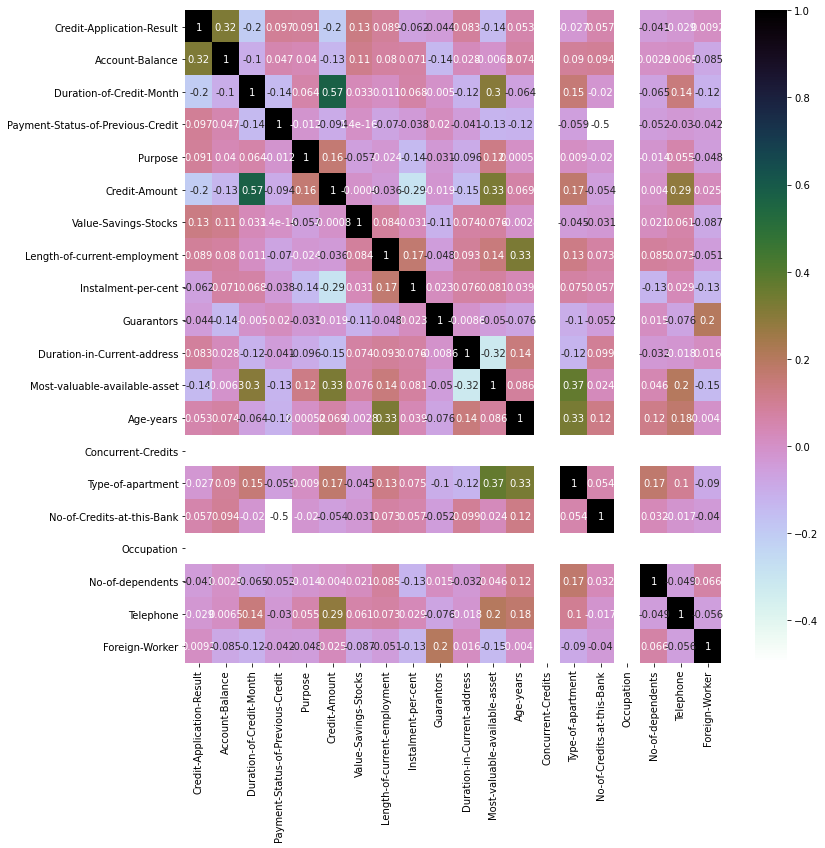

In [28]:
plt.figure(figsize=(12,12)) 
sns.heatmap(df.corr(),annot=True,cmap='cubehelix_r')
plt.show()

In [29]:
corr = df.corr()
#Correlation with output variable
cor_target = abs(corr["Credit-Application-Result"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>=0]
df_corr = pd.DataFrame(relevant_features)

In [30]:
df_corr = df_corr.reset_index()
df_corr = df_corr.rename(columns = {'Credit-Application-Result' : 'Corr', 'index': 'features'})
df_corr = df_corr.sort_values(['Corr'], ascending=False)
df_corr

,features,Corr
0,Credit-Application-Result,1.000000
1,Account-Balance,0.316080
2,Duration-of-Credit-Month,0.202504
5,Credit-Amount,0.201946
11,Most-valuable-available-asset,0.141332
6,Value-Savings-Stocks,0.133424
3,Payment-Status-of-Previous-Credit,0.096541
4,Purpose,0.090912
7,Length-of-current-employment,0.089383
10,Duration-in-Current-address,0.082826


In [31]:
df.nunique()

Credit-Application-Result              2
Account-Balance                        2
Duration-of-Credit-Month              30
Payment-Status-of-Previous-Credit      3
Purpose                                4
Credit-Amount                        464
Value-Savings-Stocks                   3
Length-of-current-employment           3
Instalment-per-cent                    4
Guarantors                             2
Duration-in-Current-address            4
Most-valuable-available-asset          4
Age-years                             53
Concurrent-Credits                     1
Type-of-apartment                      3
No-of-Credits-at-this-Bank             2
Occupation                             1
No-of-dependents                       2
Telephone                              2
Foreign-Worker                         2
dtype: int64

In [32]:
df.skew()

Credit-Application-Result           -0.960891
Account-Balance                      0.096400
Duration-of-Credit-Month             0.991000
Payment-Status-of-Previous-Credit   -0.687677
Purpose                              1.257190
Credit-Amount                        2.108522
Value-Savings-Stocks                 0.983026
Length-of-current-employment         0.637223
Instalment-per-cent                 -0.596533
Guarantors                           2.962197
Duration-in-Current-address          1.566395
Most-valuable-available-asset        0.013780
Age-years                            1.102038
Concurrent-Credits                   0.000000
Type-of-apartment                   -0.056348
No-of-Credits-at-this-Bank           0.585090
Occupation                           0.000000
No-of-dependents                     2.011101
Telephone                            0.409478
Foreign-Worker                       4.847285
dtype: float64

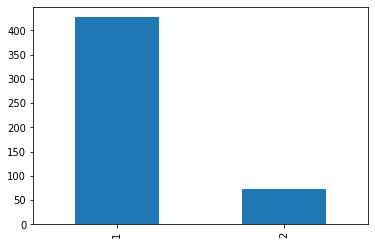

In [33]:
df['No-of-dependents'].value_counts().sort_index().plot.bar()

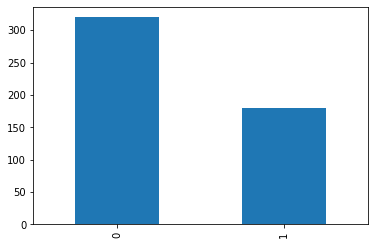

In [34]:
df['No-of-Credits-at-this-Bank'].value_counts().sort_index().plot.bar()

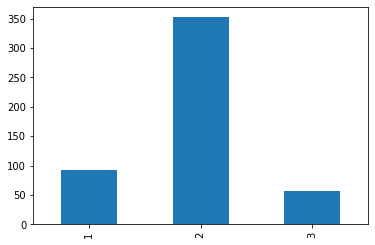

In [35]:
df['Type-of-apartment'].value_counts().sort_index().plot.bar()

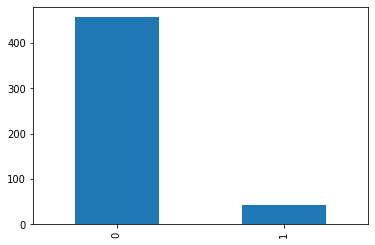

In [36]:
df['Guarantors'].value_counts().sort_index().plot.bar()

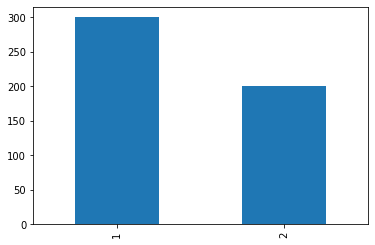

In [37]:
df['Telephone'].value_counts().sort_index().plot.bar()

Data to be excluded:
1. Concurrent-credits and Occupation (Because only have 1 values)
2. Foreign-Worker, Guarantors and No-of-dependents (Because of skewed to 1 data only)
3. Duration in current address is removed because has 344 empty records


In [38]:
df = df.drop(columns=["Duration-in-Current-address",
                      'Concurrent-Credits',
                      'Guarantors',
                      'Foreign-Worker', 
                      'Occupation', 
                      'Telephone', 
                      'No-of-dependents',
                     'Duration-of-Credit-Month',
                     "Instalment-per-cent"])

In [39]:
X1 = df.drop(columns=['Credit-Application-Result'])
y1 = df['Credit-Application-Result']

print(X1.shape)
print(y1.shape)

print(df.info())


(500, 10)
(500,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Credit-Application-Result          500 non-null    int64  
 1   Account-Balance                    500 non-null    int64  
 2   Payment-Status-of-Previous-Credit  500 non-null    int64  
 3   Purpose                            500 non-null    int64  
 4   Credit-Amount                      500 non-null    int64  
 5   Value-Savings-Stocks               500 non-null    int64  
 6   Length-of-current-employment       500 non-null    int64  
 7   Most-valuable-available-asset      500 non-null    int64  
 8   Age-years                          500 non-null    float64
 9   Type-of-apartment                  500 non-null    int64  
 10  No-of-Credits-at-this-Bank         500 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 43

In [40]:
X = np.array(X1)
y = np.array(y1)

**Check whether the data is balanced or not**

In [41]:
positive = df[df["Credit-Application-Result"]== 1]
negative = df[df["Credit-Application-Result"]== 0]

ratio = float(len(negative) / len(positive))
print(ratio)


print("positive:{}".format(len(positive)))
print("negative:{}".format(len(negative)))

0.39664804469273746
positive:358
negative:142


In [42]:
random_state = 1
X_train, X_val, y_train,y_val = train_test_split(X,y, test_size = 0.3, stratify=y, random_state=random_state)

In [43]:
model = sm.OLS(y1, X1)
fit = model.fit()
print(fit.summary())

                                    OLS Regression Results                                    
Dep. Variable:     Credit-Application-Result   R-squared (uncentered):                   0.759
Model:                                   OLS   Adj. R-squared (uncentered):              0.754
Method:                        Least Squares   F-statistic:                              154.1
Date:                       Sun, 08 Aug 2021   Prob (F-statistic):                   2.68e-144
Time:                               06:45:48   Log-Likelihood:                         -270.49
No. Observations:                        500   AIC:                                      561.0
Df Residuals:                            490   BIC:                                      603.1
Df Model:                                 10                                                  
Covariance Type:                   nonrobust                                                  
                                        coef    st

### Provided test dataset

In [44]:
df_test = pd.read_csv("../content/drive/My Drive/Colab Notebooks/Udacity/customers-to-score.csv")
df_test

,Account-Balance,Duration-of-Credit-Month,Payment-Status-of-Previous-Credit,Purpose,Credit-Amount,Value-Savings-Stocks,Length-of-current-employment,Instalment-per-cent,Guarantors,Duration-in-Current-address,Most-valuable-available-asset,Age-years,Concurrent-Credits,Type-of-apartment,No-of-Credits-at-this-Bank,Occupation,No-of-dependents,Telephone,Foreign-Worker
0,No Account,9,No Problems (in this bank),Home Related,2799,None,< 1yr,2,None,2,1,36,Other Banks/Depts,1,More than 1,1,2,1,1
1,No Account,12,No Problems (in this bank),Home Related,2122,None,< 1yr,3,None,2,1,39,Other Banks/Depts,1,More than 1,1,2,1,2
2,No Account,24,Paid Up,Home Related,3758,£100-£1000,< 1yr,1,None,4,4,23,Other Banks/Depts,1,1,1,1,1,1
3,No Account,11,No Problems (in this bank),Home Related,3905,None,< 1yr,2,None,2,1,36,Other Banks/Depts,1,More than 1,1,2,1,1
4,No Account,6,No Problems (in this bank),Home Related,1957,None,1-4 yrs,1,None,4,3,31,Other Banks/Depts,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,No Account,18,No Problems (in this bank),Home Related,3966,None,4-7 yrs,1,None,4,1,33,Other Banks/Depts,1,More than 1,1,1,2,1
496,No Account,12,Some Problems,Home Related,6199,None,< 1yr,4,None,2,2,28,Other Banks/Depts,1,More than 1,1,1,2,1
497,No Account,24,Paid Up,Home Related,1987,None,< 1yr,2,None,4,1,21,Other Banks/Depts,1,1,1,2,1,1
498,No Account,24,Paid Up,Home Related,2303,None,4-7 yrs,4,Yes,1,1,45,Other Banks/Depts,2,1,1,1,1,1


In [45]:
df_test['Account-Balance'].unique()

array(['No Account', 'Some Balance'], dtype=object)

In [46]:
df_test['Account-Balance'].replace({'Some Balance': 1, 'No Account': 0}, inplace=True)

In [47]:
df_test['Payment-Status-of-Previous-Credit'].unique()

array(['No Problems (in this bank)', 'Paid Up', 'Some Problems'],
      dtype=object)

In [48]:
df_test['Payment-Status-of-Previous-Credit'].replace({'Paid Up': 2, 'No Problems (in this bank)': 1, 'Some Problems': 0}, inplace=True)

In [49]:
df_test["Purpose"].unique()

array(['Home Related', 'New car', 'Used car'], dtype=object)

In [50]:
df_test['Purpose'].replace({
                    'New car': 3, 
                    'Used car': 2,
                    'Home Related': 1,
                    'Other': 0}, inplace=True)

In [51]:
df_test['Value-Savings-Stocks'].unique()

array(['None', '£100-£1000', '< £100'], dtype=object)

In [52]:
df_test['Value-Savings-Stocks'].replace({
                    '< £100': 2, 
                    '£100-£1000': 1,
                    'None': 0}, inplace=True)

In [53]:
df_test['Length-of-current-employment'].unique()

array(['< 1yr', '1-4 yrs', '4-7 yrs'], dtype=object)

In [54]:
df_test['Length-of-current-employment'].replace({
                    '4-7 yrs': 2, 
                    '1-4 yrs': 1,
                    '< 1yr': 0}, inplace=True)

In [55]:
df_test['Concurrent-Credits'].replace({'Other Banks/Depts': 1}, inplace=True)

In [56]:
df_test['No-of-Credits-at-this-Bank'].replace({'More than 1': 1, '1': 0}, inplace=True)

In [57]:
df_test['Guarantors'].replace({'Yes': 1, 'None': 0}, inplace=True)

In [58]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Account-Balance                    500 non-null    int64
 1   Duration-of-Credit-Month           500 non-null    int64
 2   Payment-Status-of-Previous-Credit  500 non-null    int64
 3   Purpose                            500 non-null    int64
 4   Credit-Amount                      500 non-null    int64
 5   Value-Savings-Stocks               500 non-null    int64
 6   Length-of-current-employment       500 non-null    int64
 7   Instalment-per-cent                500 non-null    int64
 8   Guarantors                         500 non-null    int64
 9   Duration-in-Current-address        500 non-null    int64
 10  Most-valuable-available-asset      500 non-null    int64
 11  Age-years                          500 non-null    int64
 12  Concurrent-Credits    

In [59]:
df_test = df_test.drop(columns=["Duration-in-Current-address",
                      'Concurrent-Credits',
                      'Guarantors',
                      'Foreign-Worker', 
                      'Occupation', 
                      'Telephone', 
                      'No-of-dependents',
                     'Duration-of-Credit-Month',
                     "Instalment-per-cent"])

In [60]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Account-Balance                    500 non-null    int64
 1   Payment-Status-of-Previous-Credit  500 non-null    int64
 2   Purpose                            500 non-null    int64
 3   Credit-Amount                      500 non-null    int64
 4   Value-Savings-Stocks               500 non-null    int64
 5   Length-of-current-employment       500 non-null    int64
 6   Most-valuable-available-asset      500 non-null    int64
 7   Age-years                          500 non-null    int64
 8   Type-of-apartment                  500 non-null    int64
 9   No-of-Credits-at-this-Bank         500 non-null    int64
dtypes: int64(10)
memory usage: 39.2 KB


In [61]:
X_test = np.array(df_test)

## Machine Learning Training



In [62]:
# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(random_state=random_state), 
               DecisionTreeClassifier(random_state=random_state),
               RandomForestClassifier(n_estimators=100, random_state=random_state),
               AdaBoostClassifier(random_state=random_state)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_val)[::,1]
    
    fpr, tpr, _ = roc_curve(y_val,  yproba)
    auc = roc_auc_score(y_val, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


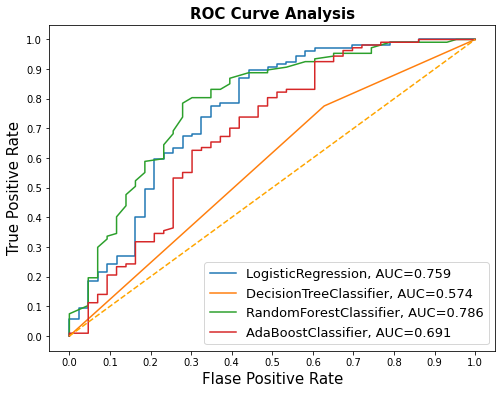

In [63]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

### Logistic Regression

In [65]:
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [66]:
y_val_pred = clf.predict(X_val)

In [67]:
y_val_score = clf.decision_function(X_val)

In [68]:
def plot_feature_importance(importance,names,model_type):
  
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

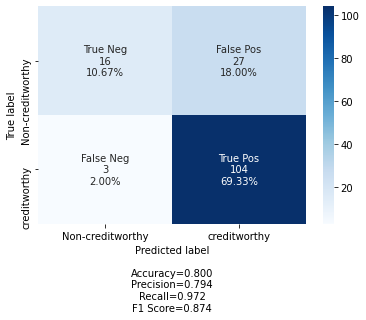

In [69]:
cf = confusion_matrix(y_val, y_val_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-creditworthy', 'creditworthy']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories)

In [70]:
print(classification_report(y_val, y_val_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

                  precision    recall  f1-score   support

Non-Creditworthy       0.84      0.37      0.52        43
    Creditworthy       0.79      0.97      0.87       107

        accuracy                           0.80       150
       macro avg       0.82      0.67      0.70       150
    weighted avg       0.81      0.80      0.77       150



In [71]:
y_test_pred = clf.predict(X_test)
y_test_score = clf.decision_function(X_test)

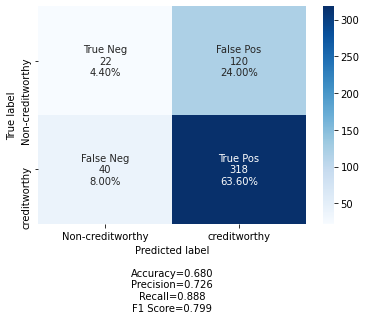

In [72]:
cf = confusion_matrix(y, y_test_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-creditworthy', 'creditworthy']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories)

In [73]:
print(classification_report(y, y_test_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

                  precision    recall  f1-score   support

Non-Creditworthy       0.35      0.15      0.22       142
    Creditworthy       0.73      0.89      0.80       358

        accuracy                           0.68       500
       macro avg       0.54      0.52      0.51       500
    weighted avg       0.62      0.68      0.63       500



### Decision Tree Classifier

In [74]:
clf = DecisionTreeClassifier().fit(X_train, y_train)

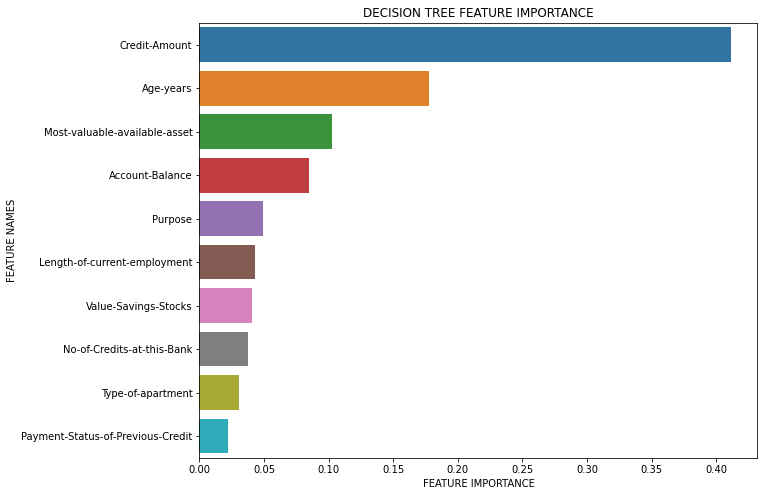

In [75]:
plot_feature_importance(clf.feature_importances_,X1.columns,'DECISION TREE ')

In [76]:
y_val_pred = clf.predict(X_val)
y_val_score = clf.predict_proba(X_val)

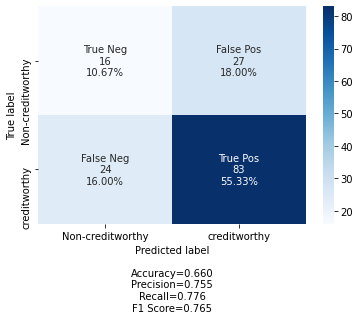

In [77]:
cf = confusion_matrix(y_val, y_val_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-creditworthy', 'creditworthy']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories)

In [78]:
print(classification_report(y_val, y_val_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

                  precision    recall  f1-score   support

Non-Creditworthy       0.40      0.37      0.39        43
    Creditworthy       0.75      0.78      0.76       107

        accuracy                           0.66       150
       macro avg       0.58      0.57      0.58       150
    weighted avg       0.65      0.66      0.66       150



In [79]:
y_test_pred = clf.predict(X_test)
y_test_score = clf.predict_proba(X_test)

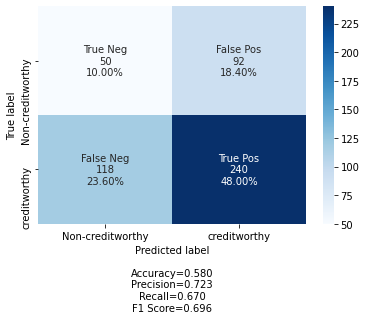

In [80]:
cf = confusion_matrix(y, y_test_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-creditworthy', 'creditworthy']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories)

In [81]:
print(classification_report(y, y_test_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

                  precision    recall  f1-score   support

Non-Creditworthy       0.30      0.35      0.32       142
    Creditworthy       0.72      0.67      0.70       358

        accuracy                           0.58       500
       macro avg       0.51      0.51      0.51       500
    weighted avg       0.60      0.58      0.59       500



### Random Forest Classifier

In [82]:
clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

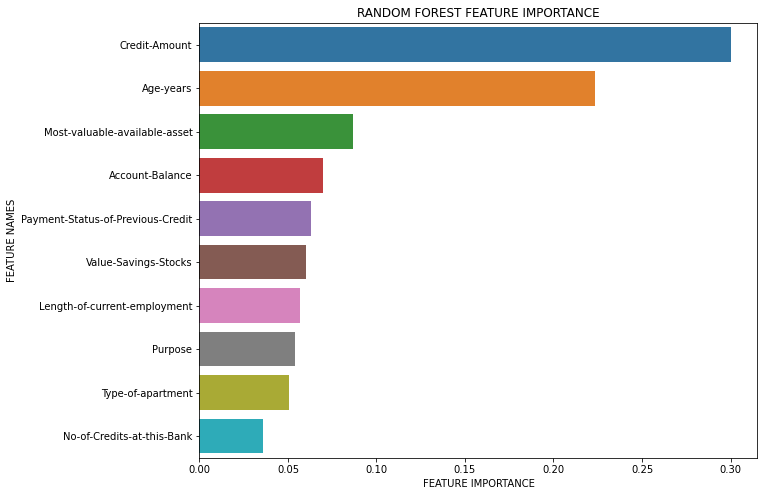

In [83]:
plot_feature_importance(clf.feature_importances_,X1.columns,'RANDOM FOREST ')

In [84]:
y_val_pred = clf.predict(X_val)
y_val_score = clf.predict_proba(X_val)

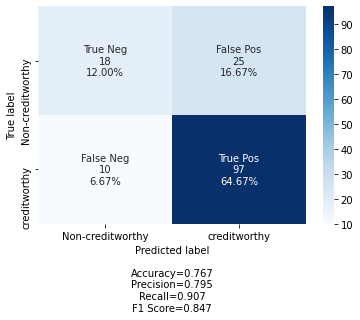

In [85]:
cf = confusion_matrix(y_val, y_val_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-creditworthy', 'creditworthy']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories)

In [86]:
print(classification_report(y_val, y_val_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

                  precision    recall  f1-score   support

Non-Creditworthy       0.64      0.42      0.51        43
    Creditworthy       0.80      0.91      0.85       107

        accuracy                           0.77       150
       macro avg       0.72      0.66      0.68       150
    weighted avg       0.75      0.77      0.75       150



In [87]:
y_test_pred = clf.predict(X_test)
y_test_score = clf.predict_proba(X_test)

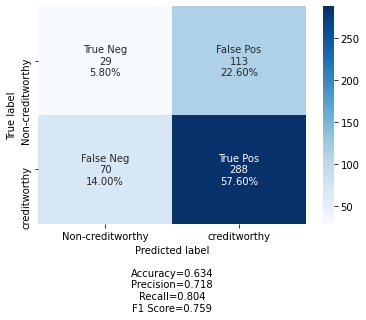

In [88]:
cf = confusion_matrix(y, y_test_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-creditworthy', 'creditworthy']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories)

In [89]:
print(classification_report(y, y_test_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

                  precision    recall  f1-score   support

Non-Creditworthy       0.29      0.20      0.24       142
    Creditworthy       0.72      0.80      0.76       358

        accuracy                           0.63       500
       macro avg       0.51      0.50      0.50       500
    weighted avg       0.60      0.63      0.61       500



### AdaBoost Classifier

In [90]:
clf = AdaBoostClassifier().fit(X_train, y_train)

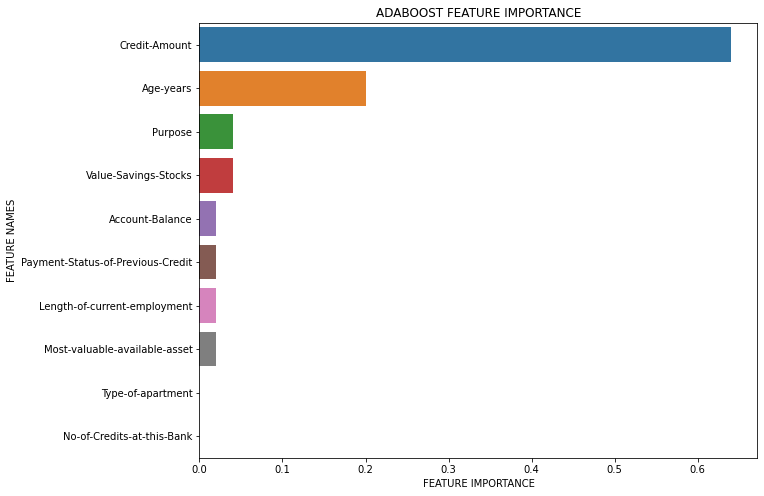

In [91]:
plot_feature_importance(clf.feature_importances_,X1.columns,'ADABOOST ')

In [92]:
y_val_pred = clf.predict(X_val)
y_val_score = clf.predict_proba(X_val)

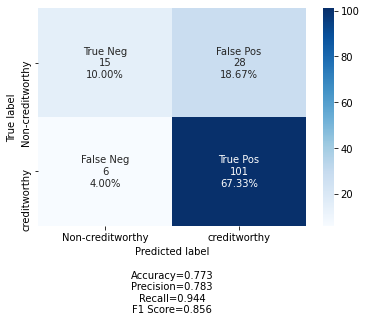

In [93]:
cf = confusion_matrix(y_val, y_val_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-creditworthy', 'creditworthy']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories)

In [94]:
print(classification_report(y_val, y_val_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

                  precision    recall  f1-score   support

Non-Creditworthy       0.71      0.35      0.47        43
    Creditworthy       0.78      0.94      0.86       107

        accuracy                           0.77       150
       macro avg       0.75      0.65      0.66       150
    weighted avg       0.76      0.77      0.74       150



In [95]:
y_test_pred = clf.predict(X_test)
y_test_score = clf.predict_proba(X_test)

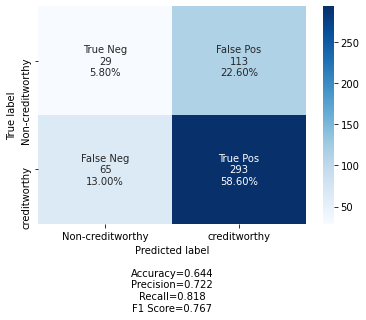

In [96]:
cf = confusion_matrix(y, y_test_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-creditworthy', 'creditworthy']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories)

In [97]:
print(classification_report(y, y_test_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

                  precision    recall  f1-score   support

Non-Creditworthy       0.31      0.20      0.25       142
    Creditworthy       0.72      0.82      0.77       358

        accuracy                           0.64       500
       macro avg       0.52      0.51      0.51       500
    weighted avg       0.60      0.64      0.62       500



### XGBoost

In [98]:
clf = XGBClassifier(learning_rate = 0.001, n_estimators=200, random_state=random_state).fit(X_train, y_train)

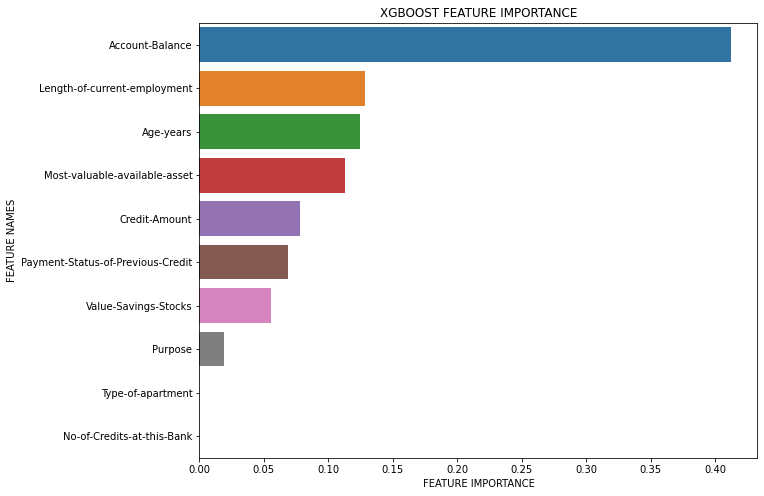

In [99]:
plot_feature_importance(clf.feature_importances_,X1.columns,'XGBOOST ')

In [100]:
y_val_pred = clf.predict(X_val)
y_val_score = clf.predict_proba(X_val)

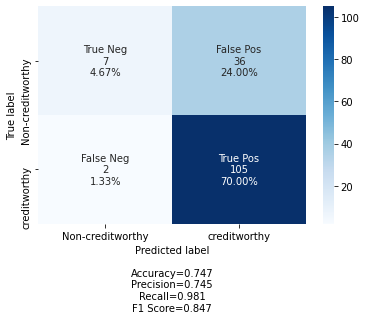

In [101]:
cf = confusion_matrix(y_val, y_val_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-creditworthy', 'creditworthy']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories)

In [102]:
print(classification_report(y_val, y_val_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

                  precision    recall  f1-score   support

Non-Creditworthy       0.78      0.16      0.27        43
    Creditworthy       0.74      0.98      0.85       107

        accuracy                           0.75       150
       macro avg       0.76      0.57      0.56       150
    weighted avg       0.75      0.75      0.68       150



In [103]:
y_test_pred = clf.predict(X_test)
y_test_score = clf.predict_proba(X_test)

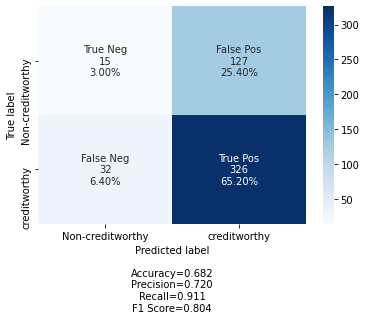

In [104]:
cf = confusion_matrix(y, y_test_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Non-creditworthy', 'creditworthy']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories)

In [105]:
print(classification_report(y, y_test_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

                  precision    recall  f1-score   support

Non-Creditworthy       0.32      0.11      0.16       142
    Creditworthy       0.72      0.91      0.80       358

        accuracy                           0.68       500
       macro avg       0.52      0.51      0.48       500
    weighted avg       0.61      0.68      0.62       500

